# New York City Taxi Trip Duration
      - Share code and data to improve ride time predictions 

In [22]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

In [23]:
# 경로 변수 (고정)


trainfile = '../_data/train_03_997.csv'
old_trainfile = '../_data/train.csv'
kaggle_trainfile = '../_data/train_k.csv'

testfile = '../_data/test_clean.csv'
old_testfile = '../_data/test.csv'

train_171016 = '../_data/171016_dow_hr_pas_L2_dur_only.csv'
train_osrm = '../_data/train_with_osrm.csv'
train_osrm_weather = '../_data/train_with_osrm_and_weather.csv'
train_osrm_weather_hourly = '../_data/train_with_osrm_and_weather_hourly.csv'
train_dropped_nan_fixed = '../_data/train__dropped__no_disaster_nan_fixed.csv'
train_added_airps = '../_data/train__dropped__lnglat_saved__airports__no_disaster.csv'
train_added_airps_cleaned = '../_data/train__dropped__cleaned__airports__no_disaster.csv'
train_added_airps_disas_cleaned = '../_data/train__dropped__cleaned__eval__airports__disaster.csv'
train_added_weekhr = '../_data/train__dropped__cleaned__eval__a_d_weekhour.csv'
train_added_manh = '../_data/train__dropped__air_bliz_weekhr_manh.csv'
train_all_vars_rough = '../_data/train__all_vars__rough.csv'

train_701778_all_vars = '../_data/train__701778__all_vars.csv'
train_700806_all_vars_cooks_dropped = '../_data/train_700806_dropped_cooks.csv'
train_700789_all_vars_cooks_dropped_circle_filter = '../_data/train_700789_dropped_cooks__circle_filter.csv'
train_700789_all_vars_cdcf_kmeans = '../_data/train_kmeans_30_added.csv'
train_700419_all_vars_cdcf150kmh_km60 = '../_data/train_kmeans_60_added_cooksd_circle_150kmh.csv'

train_700419_all_vars_4d_clust120 = '../_data/train_kmeans_4D_120.csv'
train_700419_all_vars_4d_clust120_speed = '../_data/train_kmeans_4D_120_clustspeed.csv'
train_700419_all_vars_4d_clust120_speed_glob = '../_data/train_kmeans_4D_120_clustspeed_globalized.csv'

train_700419 = '../_data/train_700419_recent.csv'
train_697355 = '../_data/train_697355_rsq_0722.csv'
train_697349 = '../_data/train_697349_rsq_0723.csv'
train_697284 = '../_data/train_697284_rsq_0725.csv'
train_696688 = '../_data/train_696688_rsq_0731.csv'

test_recent = '../_data/test_backup_clean_todo_clust.csv'

trains = [train_700419, train_697355, train_697349, train_697284, train_696688]

train_latest = trains[0]


# 1. Feature Check

## pickup, dropoff의 date 확인

In [47]:
taxiDB = pd.read_csv('../_data/train.csv', infer_datetime_format=True, parse_dates=['pickup_datetime'])
taxiDB.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
701773,id3888279,1,2016-01-01 00:01:00,1/1/16 0:05,1,-73.982292,40.751331,-73.991341,40.750340,N,280
701774,id1210365,2,2016-01-01 00:01:00,1/1/16 0:07,5,-73.965279,40.801041,-73.947479,40.815170,N,408
701775,id0924227,1,2016-01-01 00:01:00,1/1/16 0:13,1,-73.970108,40.759800,-73.989357,40.742989,N,736
701776,id0190469,2,2016-01-01 00:00:00,1/1/16 0:14,5,-73.981743,40.719158,-73.938828,40.829182,N,849
701777,id1665586,1,2016-01-01 00:00:00,1/1/16 0:22,1,-73.985085,40.747166,-73.958038,40.717491,N,1294


In [49]:
# Dates
taxiDB['pickup_date'] = taxiDB['pickup_datetime'].dt.date

# day of month 1 to 30/31
taxiDB['pickup_day'] = taxiDB['pickup_datetime'].dt.day
    
#month of year 1 to 12
taxiDB['pickup_month'] = taxiDB['pickup_datetime'].dt.month

#weekday 0 to 6
taxiDB['pickup_weekday'] = taxiDB['pickup_datetime'].dt.weekday

#week of year
taxiDB['pickup_weekofyear'] = taxiDB['pickup_datetime'].dt.weekofyear

#hour of day 0 to 23
taxiDB['pickup_hour'] = taxiDB['pickup_datetime'].dt.hour

#minute of hour
taxiDB['pickup_minute'] = taxiDB['pickup_datetime'].dt.minute

# day of year
taxiDB['pickup_dayofyear'] = taxiDB['pickup_datetime'].dt.dayofyear

In [50]:
#
taxiDB['pickup_dt'] = (taxiDB['pickup_datetime'] - taxiDB['pickup_datetime'].min()).dt.total_seconds()

#1주일을 시간 단위로
taxiDB['pickup_week_hour'] = taxiDB['pickup_weekday'] * 24 + taxiDB['pickup_hour']

### trip_duration / Month 분포

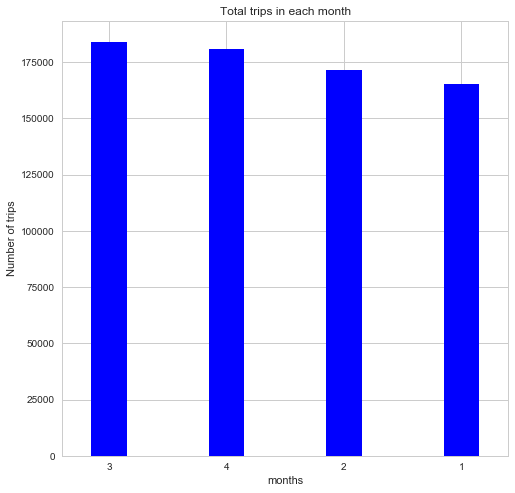

In [99]:
plt.figure(figsize=(8, 8))
taxiDB.pickup_month.value_counts().plot(kind='bar', color=["blue"], align='center', width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("months")
plt.ylabel("Number of trips")
plt.title("Total trips in each month");
plt.show()

### trip_duration / day 분포

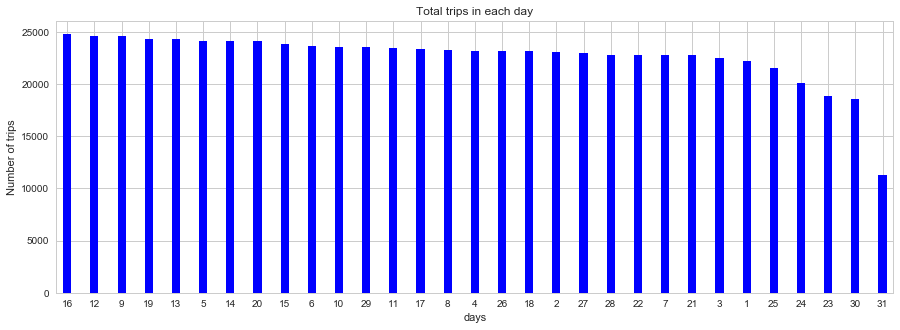

In [92]:
plt.figure(figsize=(15, 5)) 
taxiDB.pickup_day.value_counts().plot(kind='bar', color=["blue"], align='center', width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("days")
plt.ylabel("Number of trips")
plt.title("Total trips in each day");
plt.show()

### trip_duration / weekday 분포

In [106]:
taxiDB.pickup_date = pd.to_datetime(taxiDB.pickup_date)

In [109]:
weekday = taxiDB.pickup_date.dt.weekday_name

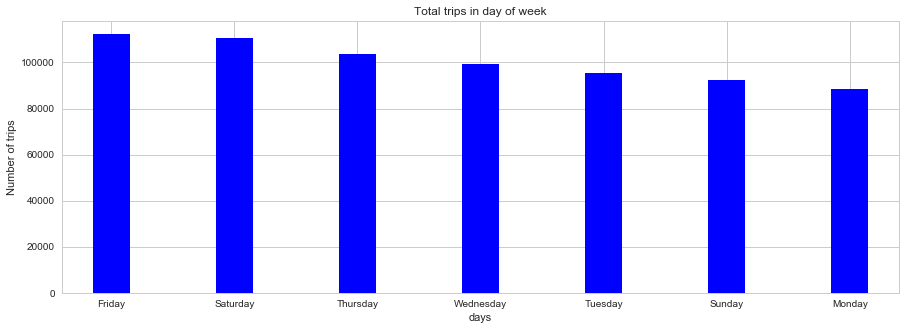

In [110]:
plt.figure(figsize=(15, 5)) 
weekday.value_counts().plot(kind='bar', color=["blue"], align='center', width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("days")
plt.ylabel("Number of trips")
plt.title("Total trips in day of week");
plt.show()

### trip_duration / hour 분포

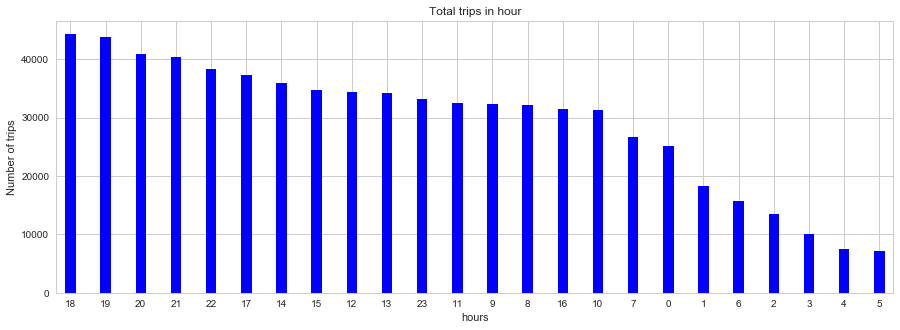

In [102]:
plt.figure(figsize=(15, 5)) 
taxiDB.pickup_hour.value_counts().plot(kind='bar', color=["blue"], align='center', width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("hours")
plt.ylabel("Number of trips")
plt.title("Total trips in hour");
plt.show()

### pickup, dropoff 분포

- 출처 - https://www.kaggle.com/selfishgene/yellow-cabs-tell-the-story-of-new-york-city

In [9]:
taxiDB = pd.read_csv('../_data/train.csv')

# remove obvious outliers
allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(taxiDB['trip_duration'], 0.3), np.percentile(taxiDB['trip_duration'], 99.7)]

taxiDB = taxiDB[(taxiDB['pickup_latitude']   >= latLimits[0] ) & (taxiDB['pickup_latitude']   <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['dropoff_latitude']  >= latLimits[0] ) & (taxiDB['dropoff_latitude']  <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['pickup_longitude']  >= longLimits[0]) & (taxiDB['pickup_longitude']  <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['dropoff_longitude'] >= longLimits[0]) & (taxiDB['dropoff_longitude'] <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['trip_duration']     >= durLimits[0] ) & (taxiDB['trip_duration']     <= durLimits[1]) ]
taxiDB = taxiDB.reset_index(drop=True)

allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

taxiDB['duration [min]'] = taxiDB['trip_duration']/60.0
taxiDB['src lat [km]']   = latMultiplier  * (taxiDB['pickup_latitude']   - medianLat)
taxiDB['src long [km]']  = longMultiplier * (taxiDB['pickup_longitude']  - medianLong)
taxiDB['dst lat [km]']   = latMultiplier  * (taxiDB['dropoff_latitude']  - medianLat)
taxiDB['dst long [km]']  = longMultiplier * (taxiDB['dropoff_longitude'] - medianLong)

allLat  = np.array(list(taxiDB['src lat [km]'])  + list(taxiDB['dst lat [km]']))
allLong = np.array(list(taxiDB['src long [km]']) + list(taxiDB['dst long [km]']))

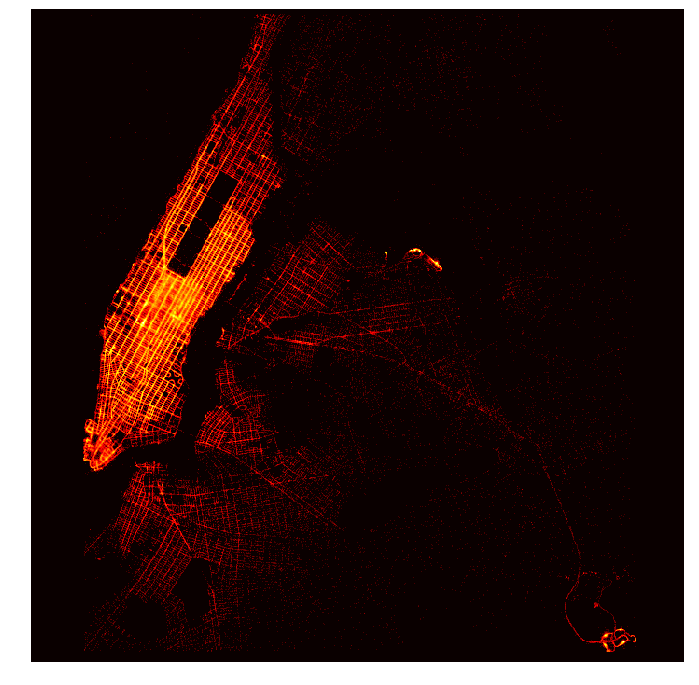

In [10]:
# show the log density of pickup and dropoff locations

imageSize = (700,700)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='hot')
ax.set_axis_off()

plt.show()

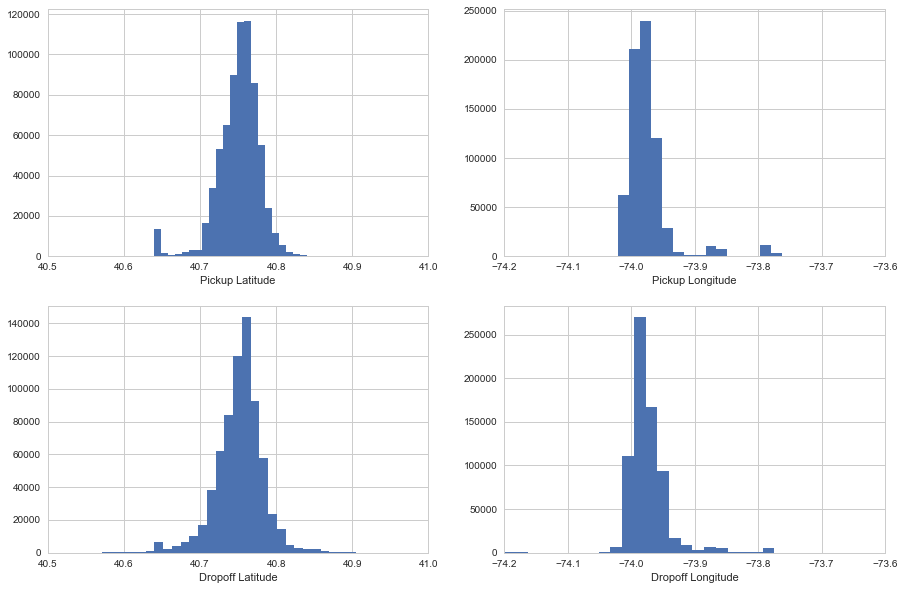

In [148]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), sharex=False, sharey = False)
ax[0,0].hist(taxiDB.pickup_latitude, bins=1000)
ax[0,1].hist(taxiDB.pickup_longitude, bins=1000)
ax[1,0].hist(taxiDB.dropoff_latitude, bins=1000)
ax[1,1].hist(taxiDB.dropoff_longitude, bins=1000)
ax[0,0].set_xlabel('Pickup Latitude')
ax[0,0].set_xlim(40.5, 41)
ax[0,1].set_xlabel('Pickup Longitude')
ax[0,1].set_xlim(-74.2, -73.6)
ax[1,0].set_xlabel('Dropoff Latitude')
ax[1,0].set_xlim(40.5, 41)
ax[1,1].set_xlabel('Dropoff Longitude')
ax[1,1].set_xlim(-74.2, -73.6);
plt.show()

## Trip Duration 분포 check
### * trip_duration vs log(trip_duration)

/home/eigensim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


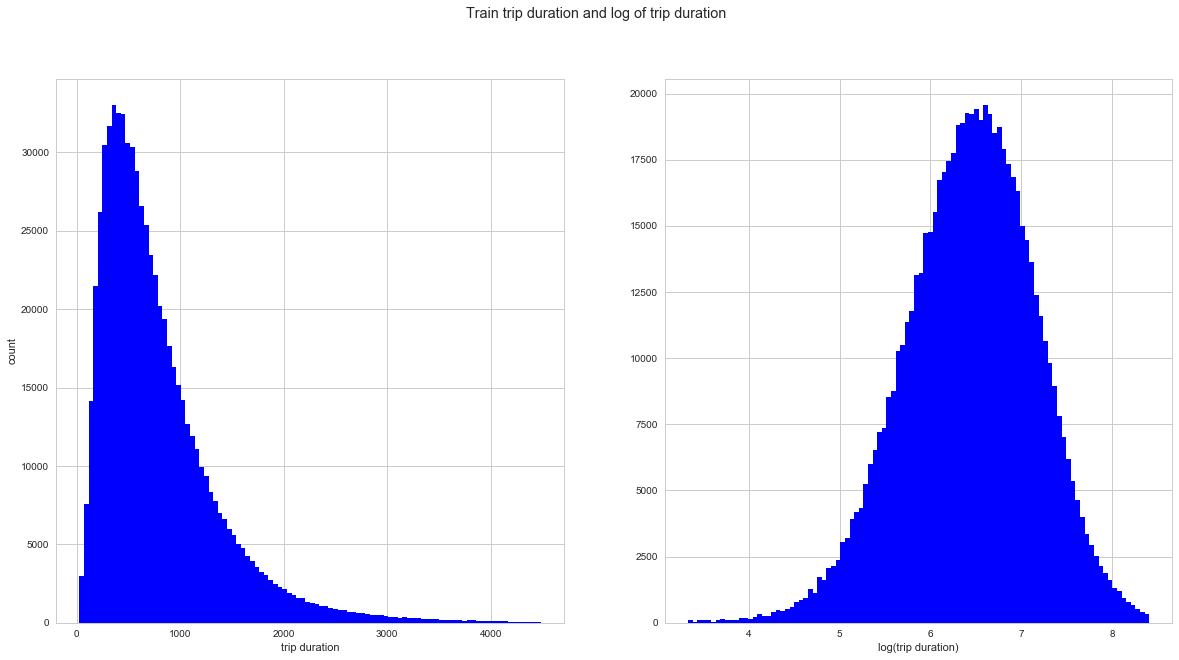

In [31]:
taxiDB['log_trip_duration'] = np.log1p(taxiDB['trip_duration'].values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Train trip duration and log of trip duration')
ax1.legend(loc=0)
ax1.set_ylabel('count')
ax1.set_xlabel('trip duration')
ax2.set_xlabel('log(trip duration)')
ax2.legend(loc=0)
ax1.hist(taxiDB.trip_duration,color='blue', bins=100)
ax2.hist(taxiDB.log_trip_duration,bins=100, color='blue');

plt.show()

# 2. variables 추가

### - 목적지까지의 최단 코스 및 소요 시간, 주말 외 공휴일, 날씨(비, 눈, 온도, 습도, 바람), 구역 분할(도심 및 공항)

<img src="../_data/images/laguardia_map.png" style="width: 500px;"/> 
<img src="../_data/images/jfk_map.png" style="width: 500px;"/>

In [6]:
pd.options.display.max_columns = 50

In [7]:
df_train = pd.read_csv(train_701778_all_vars)

In [151]:
df_train.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [152]:
df_train.shape

(701778, 30)

# circle filter (`701778 -> 701760`)

<img src="../_data/images/nycircle.png" style="width: 500px;"/> 

In [8]:
df_copy = df_train.copy()

In [9]:
center_coords = np.array((-74.002786, 40.728319))  # NYC Washington Square Park
edge_coords = np.array((-75.431274, 39.771776))  # approx. 100 miles away

In [10]:
taxi_radius = np.linalg.norm(center_coords - edge_coords)
taxi_radius

1.7191720324019342

In [11]:
def within_radius(lng, lat):
    return np.linalg.norm(center_coords - np.array([lng, lat])) < taxi_radius

## filter pickup coordinates outside of radius

In [12]:
df_circlep = df_train.loc[np.vectorize(within_radius)(\
                            df_train['p_lng'],
                            df_train['p_lat'])].copy()
df_circlep.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [167]:
df_circlep.shape

(701764, 30)

## filter dropoff coordinates outside of radius

In [13]:
df_circle = df_circlep.loc[np.vectorize(within_radius)(\
                            df_circlep['d_lng'],
                            df_circlep['d_lat'])].copy()
df_circle.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [169]:
df_circle.shape

(701760, 30)

In [170]:
df_circle.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


## resulting extremes

In [171]:
for col in ['p_lng', 'p_lat', 'd_lng', 'd_lat']:
    print(col)
    print(" min = {}".format(np.percentile(df_circle[col], 0)))
    print(" 0.3 = {}".format(np.percentile(df_circle[col], 0.3)))
    print("99.7 = {}".format(np.percentile(df_circle[col], 99.7)))
    print(" max = {}".format(np.percentile(df_circle[col], 100)))

p_lng
 min = -75.24149323
 0.3 = -74.01612854
99.7 = -73.7767868
 max = -73.22267914
p_lat
 min = 40.22580338
 0.3 = 40.64365005
99.7 = 40.82313707649
 max = 41.69679642
d_lng
 min = -75.57015228
 0.3 = -74.03293573416
99.7 = -73.77871152351
 max = -72.67115021
d_lat
 min = 40.22579956
 0.3 = 40.63078138351
99.7 = 40.86590746649
 max = 41.69335175


# Fox criterion filter (`701760 -> 700789`)

In [172]:
df_circle.to_csv('../_data/train__701760__in_circle__all_vars.csv', index=False)

In [173]:
center_coords = np.array((-74.002786, 40.728319))
edge_coords = np.array((-75.431274, 39.771776))

taxi_radius = np.linalg.norm(center_coords - edge_coords)
taxi_radius

taxi_radius = 1

def within_radius(lng, lat):
    return np.linalg.norm(center_coords - np.array([lng, lat])) < taxi_radius

df_circlep = df_train.loc[np.vectorize(within_radius)(\
                            df_train['p_lng'],
                            df_train['p_lat'])].copy()
df_circlep.head()

df_circlep.shape

df_circle = df_circlep.loc[np.vectorize(within_radius)(\
                            df_circlep['d_lng'],
                            df_circlep['d_lat'])].copy()
df_circle.head()

df_circle.shape

df_circle.head()

for col in ['p_lng', 'p_lat', 'd_lng', 'd_lat']:
    print(col)
    print(" min = {}".format(np.percentile(df_circle[col], 0)))
    print(" 0.3 = {}".format(np.percentile(df_circle[col], 0.3)))
    print("99.7 = {}".format(np.percentile(df_circle[col], 99.7)))
    print(" max = {}".format(np.percentile(df_circle[col], 100)))

df_circle.to_csv('../_data/train__701760__in_circle__all_vars.csv', index=False)

p_lng
 min = -74.61244202
 0.3 = -74.01612854
99.7 = -73.7767868
 max = -73.22267914
p_lat
 min = 40.22580338
 0.3 = 40.64365005
99.7 = 40.82313058464
 max = 41.69679642
d_lng
 min = -74.77542877
 0.3 = -74.03287310671999
99.7 = -73.77881640312
 max = -73.05597687
d_lat
 min = 40.22579956
 0.3 = 40.6308005704
99.7 = 40.86583700344
 max = 41.69335175


In [14]:
df_copy = df_circle.copy()

In [ ]:
from datetime import datetime
t0 = datetime.now()
mod = sm.OLS.from_formula('dur ~ C(is_hol)\
                               + C(dow):C(hr)\
                               + scale(total_dist) - 1', data=df_copy)
res = mod.fit()
print('done')
t1 = datetime.now()

print("{} sec".format((t1 - t0).seconds))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/eigensim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-175-58b01bf36364>", line 4, in <module>
    res = mod.fit()
  File "/home/eigensim/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py", line 190, in fit
    self.pinv_wexog, singular_values = pinv_extended(self.wexog)
  File "/home/eigensim/anaconda3/lib/python3.6/site-packages/statsmodels/tools/tools.py", line 353, in pinv_extended
    np.transpose(u)))
MemoryError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/eigensim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1821, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'MemoryError' object has no attribute '_render_traceback_'

During handling of the above exc

In [175]:
res.df_resid

NameError: name 'res' is not defined

ERROR! Session/line number was not unique in database. History logging moved to new session 127


In [21]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dur   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     28.73
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        19:48:11   Log-Likelihood:            -7.1833e+06
No. Observations:              701760   AIC:                         1.437e+07
Df Residuals:                  701590   BIC:                         1.437e+07
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
C(is_hol)[False]                889.2898    103.874      8.561      0.000     685.701    1092.879
C(is_hol)[True]                 792.0794    116.101      6.822      0.000     564.525    1019.634
C(hr)[T.1]                      -99.5045    163.872     -0.607      0.544    -420.689     221.680
C(hr)[T.2]                     -119.0740    183.258     -0.650      0.516    -478.254     240.106
C(hr)[T.3]                       76.7425    202.405      0.379      0.705    -319.965     473.450
C(hr)[T.4]                      -48.1287    225.013     -0.214      0.831    -489.146     392.889
C(hr)[T.5]                     -311.0358    220.987     -1.407      0.159    -744.163     122.091
C(hr)[T.6]                     -279.4025    165.788     -1.685      0.092    -604.341      45.537
C(hr)[T.7]                      -14.9349    141.791     -0.105      0.916    -292.840     262.970
C(hr)[T.8]                      118.0594    137.802      0.857      0.392    -152.028     388.147
C(hr)[T.9]                      178.7405    139.536      1.281      0.200     -94.745     452.226
C(hr)[T.10]                     147.5742    143.369      1.029      0.303    -133.424     428.572
C(hr)[T.11]                     121.5771    142.470      0.853      0.393    -157.660     400.814
C(hr)[T.12]                     158.4870    140.402      1.129      0.259    -116.697     433.671
C(hr)[T.13]                     135.3013    140.328      0.964      0.335    -139.737     410.340
C(hr)[T.14]                     150.6518    137.766      1.094      0.274    -119.365     420.668
C(hr)[T.15]                     346.5636    139.768      2.480      0.013      72.623     620.504
C(hr)[T.16]                     191.5145    144.251      1.328      0.184     -91.212     474.241
C(hr)[T.17]                     132.5709    137.342      0.965      0.334    -136.615     401.757
C(hr)[T.18]                     128.1364    131.613      0.974      0.330    -129.821     386.094
C(hr)[T.19]                      77.6548    130.631      0.594      0.552    -178.377     333.686
C(hr)[T.20]                      40.6934    132.989      0.306      0.760    -219.960     301.347
C(hr)[T.21]                      12.0261    133.681      0.090      0.928    -249.984     274.036
C(hr)[T.22]                      31.1307    132.718      0.235      0.815    -228.991     291.253
C(hr)[T.23]                     129.7318    132.979      0.976      0.329    -130.904     390.367
C(dow)[T.Monday]:C(hr)[0]      -234.5950    182.818     -1.283      0.199    -592.913     123.723
C(dow)[T.Saturday]:C(hr)[0]       5.0863    135.615      0.038      0.970    -260.714     270.886
C(dow)[T.Sunday]:C(hr)[0]       -33.2588    136.527     -0.244      0.808    -300.847     234.330
C(dow)[T.Thursday]:C(hr)[0]    -181.2592    1

In [15]:
df_dropped = pd.DataFrame(columns=df_copy.columns)
df_dropped

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur


In [20]:
# dropping outliers by fox_criteria
# original author: 조성빈
def dropping_outliers1(fmla, data):
    model = sm.OLS.from_formula(fmla, data)
    result = model.fit()
    influence = result.get_influence()
    cooks_d2, pvals = influence.cooks_distance
    fox_cr = 4 / (result.df_resid -1)
    print("Fox criterion for Cook's distance:", fox_cr)
    idx = np.where(cooks_d2 > fox_cr)[0]
    df_dropped = data.loc[idx].copy()
    data = data.drop(data.index[idx])
    print("Function dropping_outliers:        " + str(len(idx)) + ' rows have been deleted')
    return data, df_dropped

In [16]:
df_copy = df_circle.copy()

In [17]:
df_copy.shape

(701760, 30)

In [ ]:
from datetime import datetime

t0 = datetime.now()
fmla = 'dur ~ C(is_hol) + C(dow):C(hr) + scale(total_dist) - 1'

df_copy2, df_dropped = dropping_outliers1(fmla, df_copy)

t1 = datetime.now()

print(t1 - t0)

df_copy2.head()

## dropped rows
* high duration

In [83]:
df_dropped.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
55,False,0,430,Saturday,23,143,0.020996,1,False,False,False,False,-74.005669,40.745209,-73.989098,40.758102,2512.4,309.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,86073
405,False,0,430,Saturday,22,142,0.010217,2,False,False,False,False,-73.976662,40.747765,-73.967712,40.752693,1265.4,135.2,65,46,0.0,0.0,0.0,11.1,0.53,1.7,5.6,0.0,0.0,86323
991,False,0,430,Saturday,21,141,0.014269,1,False,False,False,False,-73.991150,40.750629,-73.987946,40.736725,1889.9,265.7,65,46,0.0,0.0,0.0,11.7,0.47,0.6,11.1,0.0,0.0,86356
2617,False,0,430,Saturday,16,136,0.180187,1,True,False,False,False,-73.782318,40.644741,-73.944893,40.722439,20929.1,1333.6,65,46,0.0,0.0,0.0,16.7,0.34,0.6,11.1,0.0,0.0,26722
3201,False,0,430,Saturday,14,134,0.027076,5,False,False,False,False,-73.990387,40.737202,-74.012169,40.721119,3387.8,420.1,65,46,0.0,0.0,0.0,16.7,0.38,2.2,13.0,0.0,0.0,86317


In [39]:
top_5 = df_copy2['dur'].sort_values(ascending=False).head().index

## remaining rows
* not ideal

In [43]:
df_copy2.loc[top_5]

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
342274,False,0,304,Friday,18,114,0.033882,1,False,False,False,False,-73.981911,40.778702,-73.957123,40.801800,4892.3,339.9,39,30,0.11,0.4,0.0,3.9,0.45,-7.2,18.5,31.5,0.0,18439
234110,False,0,322,Tuesday,19,43,0.126448,1,False,True,False,False,-73.870949,40.773830,-73.994087,40.745090,14809.7,1017.7,56,35,0.00,0.0,0.0,12.8,0.29,-5.0,13.0,0.0,0.0,15418
609652,False,0,117,Sunday,17,161,0.012918,1,False,False,False,False,-73.982101,40.755665,-73.991684,40.764328,2370.8,226.5,42,30,0.05,0.4,0.0,-0.6,0.76,-4.4,11.1,0.0,0.0,14243
78734,False,0,417,Sunday,11,155,0.010871,1,True,False,False,False,-73.790039,40.646923,-73.793320,40.657288,2416.6,266.7,75,44,0.00,0.0,0.0,13.3,0.37,-1.1,0.0,0.0,0.0,14160
533186,False,0,201,Monday,18,18,0.046676,1,False,False,False,False,-73.972336,40.761059,-73.998100,40.722137,5602.9,687.3,59,44,0.01,0.0,2.0,11.1,0.47,0.0,5.6,0.0,0.3,13850


In [44]:
df_dropped['dur'].sort_values(ascending=False).head()

991      86356
405      86323
3201     86317
15689    86299
13157    86245
Name: dur, dtype: int64

In [45]:
df_copy2.shape

(700789, 30)

In [73]:
df_copy2.to_csv('../_data/train_700806_dropped_cooks.csv', index=False)

In [49]:
df_copy = df_copy2.copy()

In [86]:
t0 = datetime.now()
modelz = sm.OLS.from_formula(fmla, df_copy2)
resz = modelz.fit()
print('done')
t1 = datetime.now()
print(t1-t0)

done
0:00:32.735062


# average speed filter (150km/h) `700789 -> 700419`

In [50]:
df_copy.insert(17, 'avg_spd', 3.6*df_copy['total_dist'] / df_copy['dur'])
df_copy.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,avg_spd,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,24.786272,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,26.462172,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,30.890731,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,12.271050,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,10.808758,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [52]:
df_copy.loc[df_copy['avg_spd'] > 150, 'avg_spd'].shape

(370,)

In [53]:
df_copy.loc[df_copy['avg_spd'] > 150, 'avg_spd'].index

Int64Index([  2820,   9603,  12063,  12486,  15405,  16299,  19217,  21857,
             22591,  23861,
            ...
            682556, 684886, 686714, 693314, 693708, 694426, 694563, 695946,
            701288, 701544],
           dtype='int64', length=370)

In [5]:
df_bkup = df_copy.copy()

NameError: name 'df_copy' is not defined

In [55]:
df_copy.drop(df_copy.loc[df_copy['avg_spd'] > 150, 'avg_spd'].index, inplace=True)

In [56]:
df_copy.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,avg_spd,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,24.786272,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,26.462172,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,30.890731,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,12.271050,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,10.808758,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [4]:
df_copy.shape

NameError: name 'df_copy' is not defined

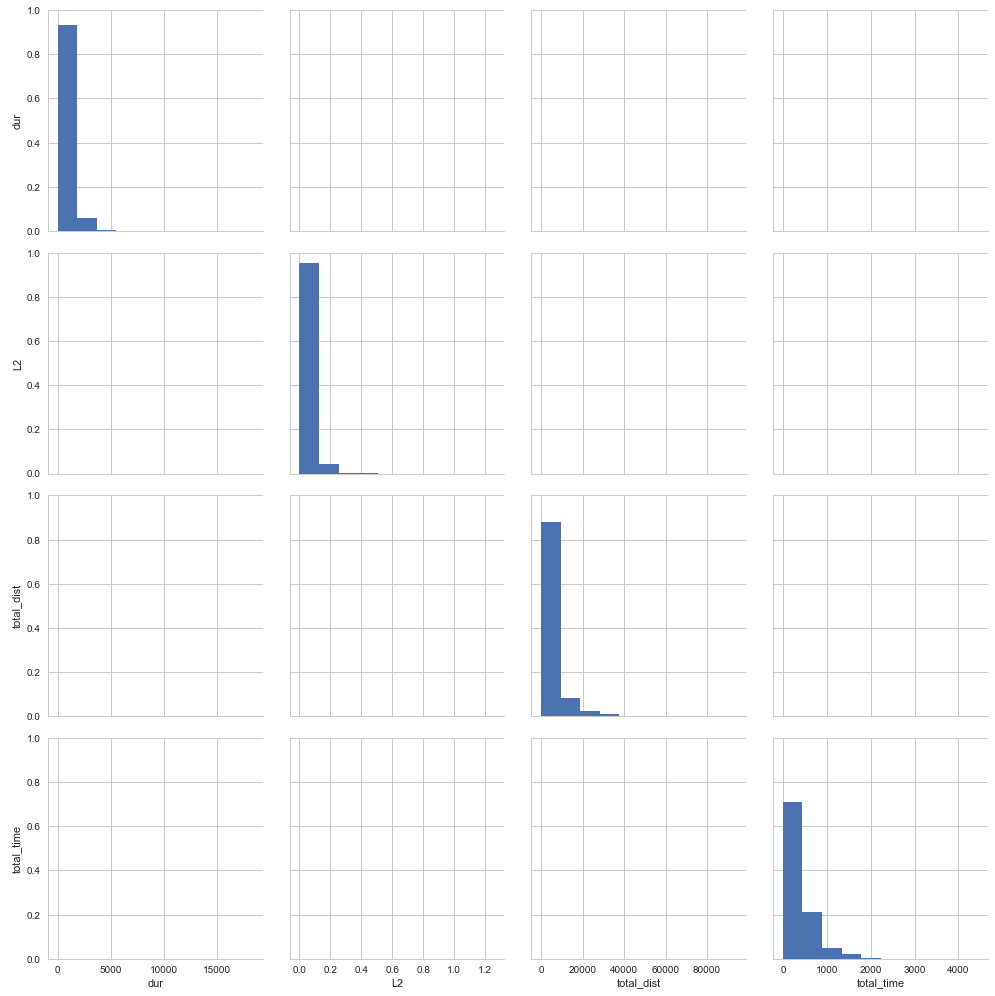

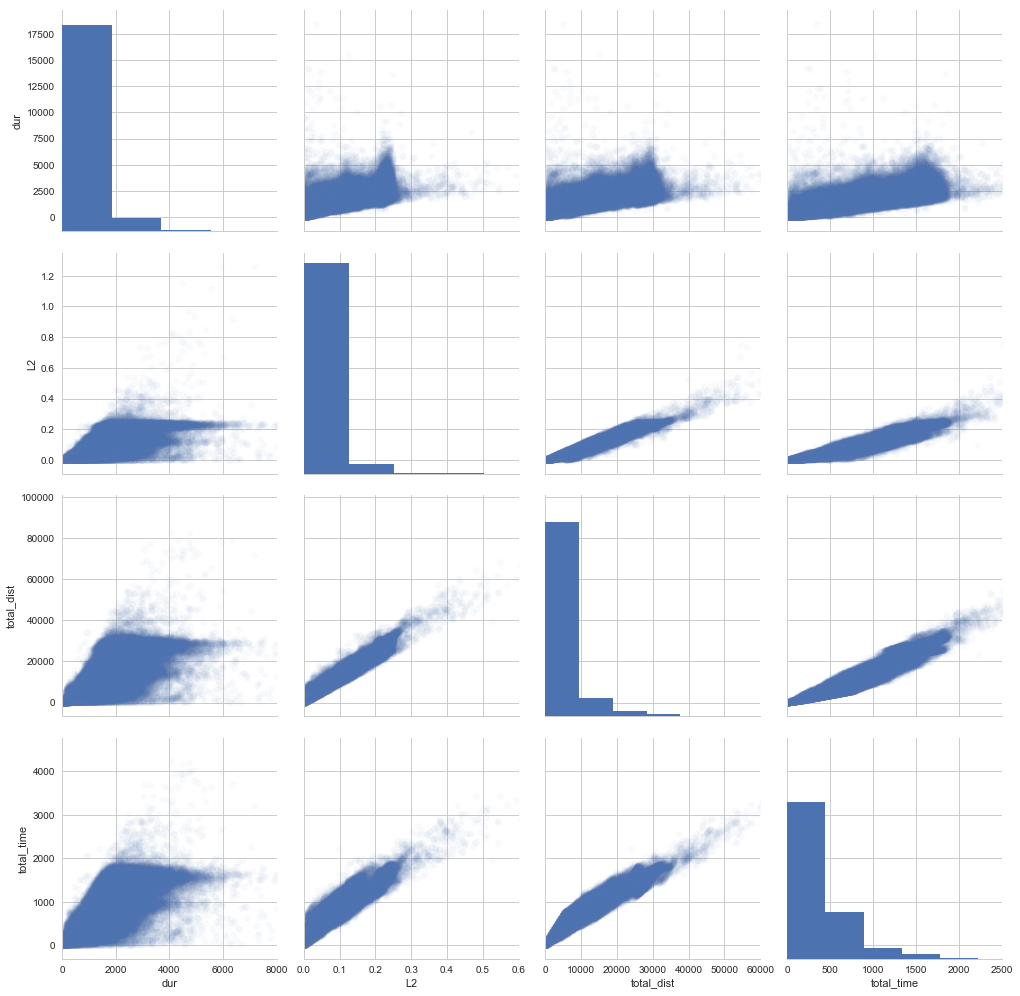

In [38]:
fdf = pd.read_csv(train_697284)

x = fdf.iloc[:, :]
y = fdf.iloc[:, :]

xcols = ['L2', 'total_dist', 'total_time']

sns_plot = sns.pairplot(pd.concat([y.dur, x[xcols[:]]], axis=1), size=3.5, plot_kws={"s": 50, 'alpha' : 0.03})

axes = sns_plot.axes

axes[0,0].set_xlim(0, 8000)
axes[1,0].set_xlim(0, 8000)
axes[2,0].set_xlim(0, 8000)
axes[3,0].set_xlim(0, 8000)
axes[0,1].set_xlim(0, 0.6)
axes[1,1].set_xlim(0, 0.6)
axes[2,1].set_xlim(0, 0.6)
axes[3,1].set_xlim(0, 0.6)
axes[0,2].set_xlim(0, 60000)
axes[1,2].set_xlim(0, 60000)
axes[2,2].set_xlim(0, 60000)
axes[3,2].set_xlim(0, 60000)
axes[0,3].set_xlim(0, 2500)
axes[1,3].set_xlim(0, 2500)
axes[2,3].set_xlim(0, 2500)
axes[3,3].set_xlim(0, 2500)

plt.show()